# TRAFFIC SIGN CLASSIFIER

In [1]:
import pickle
import csv
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def Basic_Stats(x,name):
    
    # Print basic statisctics
    print ('*'*50)
    print ('Statistics of '+name)
    s=sp.stats.describe(x)
    print ('Minimum Class:', s[1][0] )
    print ('Max Class:', s[1][1])
    print ('Total Number of Observations:', s[0])
    print ('Mean:', s[2])
    print ('Std dev:', np.sqrt(s[3]))
    print ('*'*50)

def Plot_Histogram(x,n_classes):
    # Visualize distribution of classes
    n,batches, patches = plt.hist(x,n_classes,facecolor='green')
    plt.xticks(range(0,n_classes+1, 2), rotation='vertical')
    plt.xlabel('Signs')
    plt.ylabel ('Percent')
    plt.title ('Distribution of Classes')
    plt.show()
    
def jitter_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

def LeNet(x,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.01
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
   
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)


    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W


# Read Training and Test Data

training_file = 'train.p'
testing_file = 'test.p'
sign_name = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#Read sign names
sign_names=[]
f = open(sign_name)
csv_f = csv.reader(f)
for row in csv_f:
    sign_names.append(row)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Basic statistics
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train.shape[1:]
n_classes = (len(np.unique(np.concatenate((train['labels'],test['labels'])))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

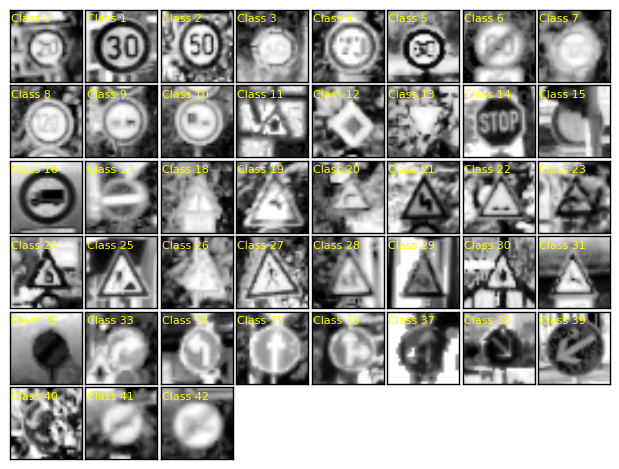

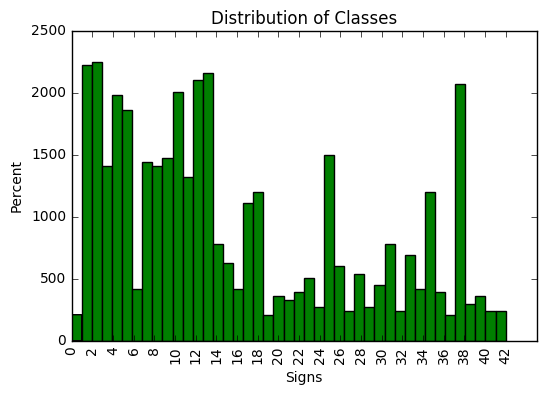

**************************************************
Statistics of Training Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 39209
Mean: 15.7883904206
Std dev: 12.0132375247
**************************************************


In [3]:
# Visualize One sign for each class
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in np.arange(n_classes):
    index=(np.ndarray.tolist(y_train)).index(i)
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    img=X_train[index,:,:,:]
    ax.imshow(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),cmap='gray')
    ax.text(0, 5, 'Class '+str(sign_names[i+1][0]),fontsize=8,color='yellow')
plt.show()

# Visualize distribution of classes
Plot_Histogram(y_train,n_classes)

# Print statistics of classes
Basic_Stats(y_train, 'Training Set')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

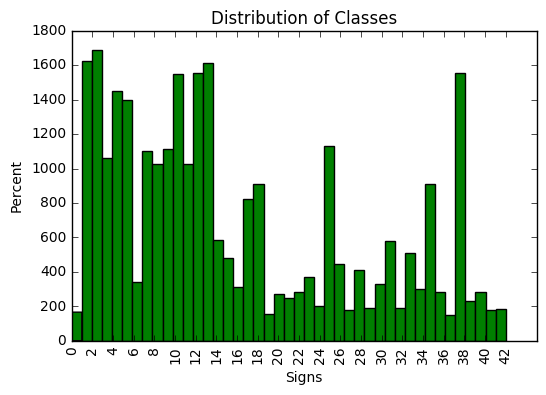

**************************************************
Statistics of Training Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 29406
Mean: 15.791913215
Std dev: 12.0111942869
**************************************************


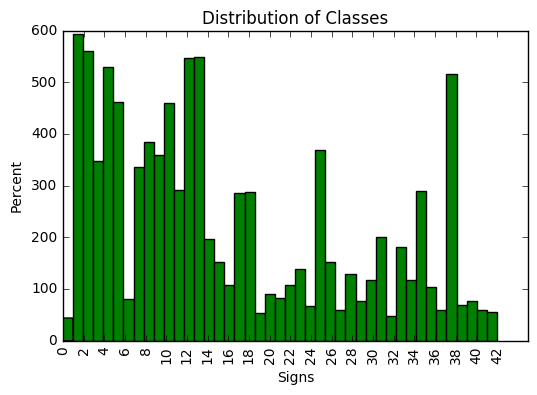

**************************************************
Statistics of Validation Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 9803
Mean: 15.7778231154
Std dev: 12.0199712186
**************************************************


In [4]:
## Split data into training, validation and test:
## X_train_dev, y_train_dev = Training Set
## X_dev, y_dev = Validation Set
## X_test, y_test = Test Set

from sklearn.model_selection import train_test_split
X_train_dev, X_dev, y_train_dev, y_dev = train_test_split(X_train, y_train, random_state=42)

Plot_Histogram(y_train_dev,n_classes)
Basic_Stats(y_train_dev, 'Training Set')

Plot_Histogram(y_dev,n_classes)
Basic_Stats(y_dev, 'Validation Set')

In [5]:
### Augument training data (exclude validation data)
AUGMENTATION_FACTOR=1
np.random.seed(100)
n,batches, patches = plt.hist(y_train_dev,n_classes,facecolor='green')
test_data_length=len(X_train_dev)*AUGMENTATION_FACTOR
target_obs_per_class=test_data_length/n_classes
Xtraindev=X_train_dev
ytraindev=y_train_dev
for i in np.arange(n_classes):
    if (n[i] < target_obs_per_class):
        index=(np.ndarray.tolist(y_train_dev)).index(i)
        image= X_train_dev[index]
        for j in np.arange(target_obs_per_class - n[i]):
            jitter_image(image,20,10,5)    
            Xtraindev=np.append(Xtraindev, [image],axis=0)
            ytraindev=np.append(ytraindev, [ytraindev[index]],axis=0)
    if (i%1000 == 0): print (i)
X_train_dev=Xtraindev
y_train_dev=ytraindev

0


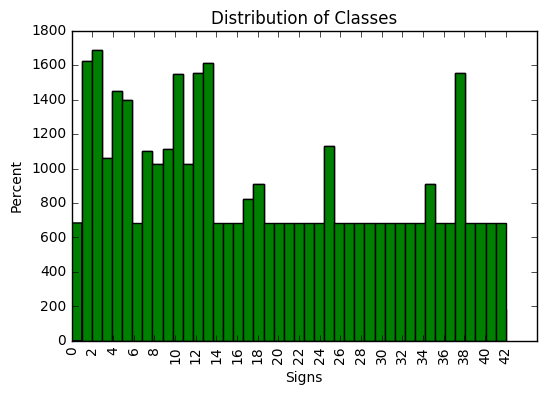

**************************************************
Statistics of Training Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 39322
Mean: 18.600071207
Std dev: 12.704891787
**************************************************


In [6]:
Plot_Histogram(y_train_dev,n_classes)
Basic_Stats(y_train_dev, 'Training Set')

In [7]:
### Grayscale, Equalize and Normalize Image

for i in np.arange(len(X_train_dev)):
#    X_train_dev[i] = X_train_dev[i]/255.0
#    X_train_dev[i]=(cv2.equalizeHist((cv2.cvtColor(X_train_dev[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))
    X_train_dev[i]=(((cv2.cvtColor(X_train_dev[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))

for i in np.arange(len(X_dev)):
#    X_dev[i] = X_dev[i]/255.0
#    X_dev[i]=(cv2.equalizeHist((cv2.cvtColor(X_dev[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))
    X_dev[i]=(((cv2.cvtColor(X_dev[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))

for i in np.arange(len(X_test)):
#    X_test[i]=(cv2.equalizeHist((cv2.cvtColor(X_test[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))
    X_test[i]=(((cv2.cvtColor(X_test[i],cv2.COLOR_BGR2GRAY))).reshape(image_shape[0],image_shape[1],1))


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [8]:
EPOCHS = 10
BATCH_SIZE = 128

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [10]:
rate = 0.001
beta = 0.01

logits,weights_1,weights_2, weights_3,weights_4, weights_5 = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3)+tf.nn.l2_loss(weights_4)+tf.nn.l2_loss(weights_5)
loss_operation = tf.reduce_mean(cross_entropy+beta*regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss/num_examples

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_dev)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_dev, y_train_dev = shuffle(X_train_dev, y_train_dev)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_dev[offset:end], y_train_dev[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        training_accuracy,training_loss = evaluate(X_train_dev, y_train_dev)
        validation_accuracy, validation_loss = evaluate(X_dev, y_dev)
        print("EPOCH {} ...".format(i+1))
        print ("Loss Operation", loss_operation)
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Training Loss = {:.3f}".format(training_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.711
Training Loss = 1.211
Validation Accuracy = 0.610
Validation Accuracy = 1.451

EPOCH 2 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.810
Training Loss = 0.818
Validation Accuracy = 0.738
Validation Accuracy = 1.029

EPOCH 3 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.882
Training Loss = 0.589
Validation Accuracy = 0.833
Validation Accuracy = 0.746

EPOCH 4 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.911
Training Loss = 0.498
Validation Accuracy = 0.873
Validation Accuracy = 0.647

EPOCH 5 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.942
Training Loss = 0.413
Validation Accuracy = 0.914
Validation Accuracy = 0.523

EPOCH 6 ...
Loss Operation Tensor("Mean:0", shape=(), dtype=float32)
Training Accuracy = 0.954
Training Loss = 0.378


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.